# FAST-UAV - Multirotor Design Optimization with Off-The-Shelf components

In this notebook, we will see how to achieve a design optimization using real off-the-shelf components instead of estimation models.

## 1. Setting up a problem with off-the-shelf components

In [1]:
import os.path as pth
import openmdao.api as om
import logging
import shutil
import fastoad.api as oad
from time import time
import matplotlib.pyplot as plt
import cma
from fastuav.utils.drivers.cmaes_driver import CMAESDriver
from fastuav.utils.postprocessing.analysis_and_plots import *

plt.rcParams["figure.figsize"] = 16, 8
plt.rcParams.update({"font.size": 13})

DATA_FOLDER_PATH = "../data"
CONFIGURATIONS_FOLDER_PATH = "../configurations"
WORK_FOLDER_PATH = "./workdir"

CONFIGURATION_FILE = pth.join(WORK_FOLDER_PATH, "multirotor_mdo_cots.yaml")
SOURCE_FILE = pth.join(DATA_FOLDER_PATH, "problem_outputs_DJI_M600_mdo.xml")

# For having log messages display on screen
logging.basicConfig(level=logging.INFO, format="%(levelname)-8s: %(message)s")

# For using all screen width
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

C:\Users\fastuav\AppData\Local\Temp\ipykernel_4604\2301580219.py:26: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
oad.generate_configuration_file(
    CONFIGURATION_FILE, overwrite=True, distribution_name="fastuav", sample_file_name="multirotor_mdo_cots.yaml"
)

INFO    : Loading FAST-OAD plugin uav
INFO    : Loading bundles from fastuav.models
INFO    : Installed bundle fastuav.models.geometry.geometry_multirotor (ID 18 )
INFO    : Installed bundle fastuav.models.structures.wing.estimation_models (ID 104 )
INFO    : Installed bundle fastuav.models.stability.static_longitudinal.neutral_point (ID 94 )
INFO    : Installed bundle fastuav.models.structures.wing.wing (ID 106 )
INFO    : Installed bundle fastuav.models.geometry.__init__ (ID 19 )
INFO    : Installed bundle fastuav.models.structures.wing.structural_analysis (ID 105 )
INFO    : Installed bundle fastuav.models.propulsion.motor.definition_parameters (ID 56 )
INFO    : Installed bundle fastuav.models.stability.static_longitudinal.static_margin (ID 95 )
INFO    : Installed bundle fastuav.models.structures.wing.__init__ (ID 107 )
INFO    : Installed bundle fastuav.models.propulsion.motor.motor (ID 58 )
INFO    : Installed bundle fastuav.models.propulsion.propeller.estimation_models (ID 66 )

INFO    : Installed bundle fastuav.models.stability.static_longitudinal.center_of_gravity.components.__init__ (ID 92 )
INFO    : Installed bundle fastuav.models.structures.wing.constraints (ID 103 )
INFO    : Installed bundle fastuav.models.propulsion.propeller.definition_parameters (ID 65 )
INFO    : Installed bundle fastuav.models.scenarios.wing_loading.wing_loading (ID 84 )
INFO    : Installed bundle fastuav.models.stability.static_longitudinal.center_of_gravity.__init__ (ID 93 )
INFO    : Installed bundle fastuav.models.scenarios.__init__ (ID 86 )
INFO    : Loaded variable descriptions in fastuav.models
INFO    : Loading FAST-OAD plugin bundled
INFO    : Loading bundles from fastoad.models
INFO    : Installed bundle fastoad.models.performances.mission.routes (ID 133 )
INFO    : Installed bundle fastoad.models.performances.mission.segments.altitude_change (ID 134 )
INFO    : Installed bundle fastoad.models.performances.mission.__init__ (ID 145 )
INFO    : Installed bundle fastoad.mo

'C:\\Users\\fastuav\\Documents\\FAST-UAV\\src\\fastuav\\notebooks\\workdir\\multirotor_mdo_cots.yaml'

The changes in the model rely in the use of catalogues instead of continuous estimation models to select the components. This is described in the configuration file by the `off_the_shelf` option when defining the model:

```yaml
model:
    scenarios:
        id: fastuav.scenarios.multirotor
    propulsion:
        id: fastuav.propulsion.multirotor
        off_the_shelf_propeller: True
```

You can check with the N2 diagram visualization that the `catalogue_selection` module has replaced the `skip_catalogue_selection` module for components where the option has been set to True.

In [3]:
N2_FILE = pth.join(WORK_FOLDER_PATH, "n2.html")
oad.write_n2(CONFIGURATION_FILE, N2_FILE, overwrite=True)
from IPython.display import IFrame
IFrame(src=N2_FILE, width="100%", height="500px")

INFO    : N2 diagram written in C:\Users\fastuav\Documents\FAST-UAV\src\fastuav\notebooks\workdir\n2.html


Now, the problem outputs from the design optimization in the continuous domain will be re-used as an initial guess for the optimization in the discrete domain.

In [4]:
oad.generate_inputs(CONFIGURATION_FILE, SOURCE_FILE, overwrite=True)

INFO    : Problem inputs written in C:\Users\fastuav\Documents\FAST-UAV\src\fastuav\notebooks\workdir\problem_inputs.xml


'C:\\Users\\fastuav\\Documents\\FAST-UAV\\src\\fastuav\\notebooks\\workdir\\problem_inputs.xml'

In [5]:
INPUT_FILE = pth.join(WORK_FOLDER_PATH, "problem_inputs.xml")
oad.variable_viewer(INPUT_FILE)

## 2. Multirotor MDO with off-the-shelf components

Due to the non-continuous nature of the selection process, the use of a gradient-based algorithm is risky. We therefore recommend the use of an evolutionary algorithm, [CMA-ES](http://www.cmap.polytechnique.fr/~nikolaus.hansen/cmaesintro.html).

### a) Using a gradient-based algorithm: SLSQP
*Convergence not guaranteed.*

In [6]:
optim_problem = oad.optimize_problem(CONFIGURATION_FILE, overwrite=True)

Iteration limit reached    (Exit mode 9)
            Current function value: 1.6136565600592605
            Iterations: 200
            Function evaluations: 2151
            Gradient evaluations: 200
Optimization FAILED.
Iteration limit reached
-----------------------------------


ERROR   : Optimization failed after 45.96 seconds
INFO    : Problem outputs written in C:\Users\fastuav\Documents\FAST-UAV\src\fastuav\notebooks\workdir\problem_outputs.xml


### b) Using an evolutionnary strategy: CMA-ES
The [pycma](https://github.com/CMA-ES/pycma) implementation of CMA-ES is used. The optimizer is wrapped with a modified version of the [OpenMDAO driver](https://github.com/OpenMDAO/RevHack2020/tree/master/problems/cma_es).<br>

*Note that the use of custom-made drivers is not supported yet by FAST-OAD. Consequently, the setup and run of the problem is made by hand.*

(5_w,11)-aCMA-ES (mu_w=3.4,w_1=42%) in dimension 12 (seed=811935, Fri Jun  2 14:36:41 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     11 4.622586673759857e+07 1.0e+00 9.11e-02  9e-02  9e-02 0:00.2
    2     22 2.194053295303322e+07 1.1e+00 8.71e-02  8e-02  9e-02 0:00.3
    3     33 2.905744362842295e+07 1.2e+00 8.03e-02  7e-02  8e-02 0:00.5
   25    275 1.549301691942712e+07 3.0e+00 3.88e-02  2e-02  5e-02 0:03.5
   54    594 1.881509301842499e+05 7.1e+00 9.95e-03  2e-03  1e-02 0:07.6
   87    957 1.586181649705919e+00 2.2e+01 5.78e-03  5e-04  8e-03 0:12.6
  100   1100 1.582123349677810e+00 2.6e+01 2.79e-03  2e-04  4e-03 0:14.4
  143   1573 1.579953685307946e+00 3.0e+01 9.79e-04  6e-05  1e-03 0:21.5
  200   2200 1.577225606465341e+00 6.0e+01 1.58e-03  9e-05  3e-03 0:29.5
  267   2937 1.564881283708676e+00 1.3e+02 2.53e-03  8e-05  4e-03 0:38.5
  300   3300 1.563982003913153e+00 1.6e+02 2.03e-03  5e-05  3e-03 0:43.0
  381   4191 5.430760898762489e+0

C:\Users\fastuav\.conda\envs\fastuav\lib\site-packages\cma\utilities\utils.py:343: UserWarning: CAVE: restart_from_best is often not useful ()
  warnings.warn(msg + ' (' +


Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1   7096 5.362606205727532e+07 1.0e+00 8.91e-02  8e-02  9e-02 0:00.3
    2   7118 1.362602650674898e+07 1.2e+00 8.55e-02  7e-02  9e-02 0:00.6
    3   7140 4.483880654056983e+07 1.3e+00 7.48e-02  6e-02  8e-02 0:00.8
   13   7360 2.028368689943963e+07 2.7e+00 4.24e-02  2e-02  4e-02 0:04.0
   29   7712 1.575513099895726e+06 7.7e+00 1.74e-02  3e-03  2e-02 0:08.2
   48   8130 4.274182138937562e+05 2.2e+01 1.78e-02  1e-03  2e-02 0:13.3
   71   8636 1.570664840827632e+00 8.7e+01 8.41e-03  2e-04  1e-02 0:19.5
   98   9230 1.559889789851093e+00 1.4e+02 1.07e-02  2e-04  2e-02 0:26.7
  100   9274 1.558098009583413e+00 1.5e+02 1.16e-02  2e-04  3e-02 0:27.3
  133  10000 1.554609418008051e+00 2.3e+02 8.19e-03  1e-04  2e-02 0:36.3
  169  10792 1.550820585602755e+00 3.3e+02 1.35e-02  1e-04  3e-02 0:46.3
  200  11474 1.549455386422901e+00 4.3e+02 6.98e-03  6e-05  1e-02 0:54.6
  243  12420 1.549062249171770e+00 7.7e+02 1.39e-03 

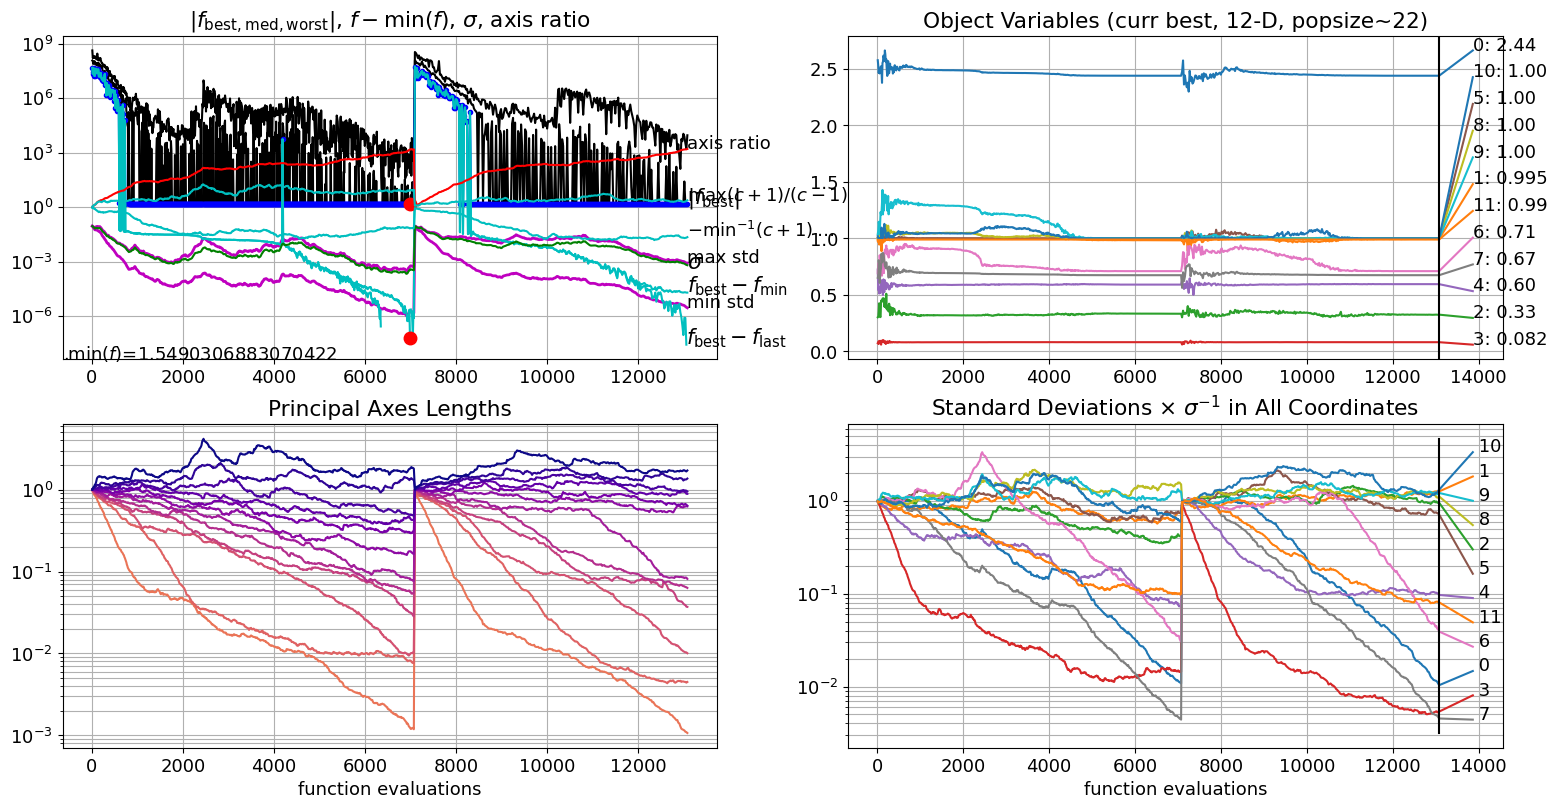

In [7]:
# Get problem configuration
conf = oad.FASTOADProblemConfigurator(CONFIGURATION_FILE)
prob = conf.get_problem(read_inputs=True, auto_scaling=True)

# CMA-ES Driver setup (see cma.CMAOptions() for all possible options for CMA-ES)
driver = prob.driver = CMAESDriver()
driver.options["sigma0"] = 0.1
driver.options[
    "penalty_parameter"
] = 1.0e8  # should be chosen such that f and the constraints violation have a similar magnitude.
driver.options["penalty_exponent"] = 1.0
driver.options["restarts"] = 1
driver.options["restart_from_best"] = True
driver.options["bipop"] = False
driver.CMAOptions["tolfun"] = 1e-6
driver.CMAOptions["tolfunhist"] = 1e-5
driver.CMAOptions["popsize_factor"] = 1
# driver.CMAOptions['CMA_stds'] = [1, 1, 100, 0.1, 0.1, 1, 1, 1, 1]
# driver.CMAOptions['CSA_dampfac'] = 1.  # positive multiplier for step-size damping
# driver.CMAOptions['CSA_squared'] = True
# driver.CMAOptions['integer_variables'] = [2]
# driver.options['augmented_lagrangian'] = True  # whether to use penalty method or augmented lagrangian for handling constraints

# Setup and run problem
prob.setup()
start_time = time()
prob.optim_failed = prob.run_driver()  # optimize
end_time = time()
computation_time = round(end_time - start_time, 2)
prob.write_outputs()

print("Objective function value ", driver.get_objective_values())

logger = cma.plot()  # plot logger

Let's save and visualize the optimization results:

In [8]:
OUTPUT_FILE = pth.join(WORK_FOLDER_PATH, "problem_outputs.xml")
DJI_M600_OUTPUT_FILE = pth.join(DATA_FOLDER_PATH, "problem_outputs_discrete_DJI_M600_mdo.xml")
shutil.copy(OUTPUT_FILE, DJI_M600_OUTPUT_FILE)
oad.optimization_viewer(CONFIGURATION_FILE)

C:\Users\fastuav\.conda\envs\fastuav\lib\site-packages\jupyter_client\session.py:719: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


In [9]:
oad.variable_viewer(OUTPUT_FILE)

## 3. Analysis and plots

We may now compare the results from the optimization in the continuous domain with the off-the-shelf configuration:

In [10]:
OUTPUT_FILE_CONTINUOUS = pth.join(DATA_FOLDER_PATH, "problem_outputs_DJI_M600_mdo.xml")
OUTPUT_FILE_DISCRETE = pth.join(DATA_FOLDER_PATH, "problem_outputs_discrete_DJI_M600_mdo.xml")
fig = multirotor_geometry_plot(OUTPUT_FILE_CONTINUOUS, name="Drone custom")
fig = multirotor_geometry_plot(OUTPUT_FILE_DISCRETE, name="Drone off-the-shelf", fig=fig)
fig.show()

In [11]:
fig = mass_breakdown_sun_plot_drone(OUTPUT_FILE_DISCRETE)
fig.show()

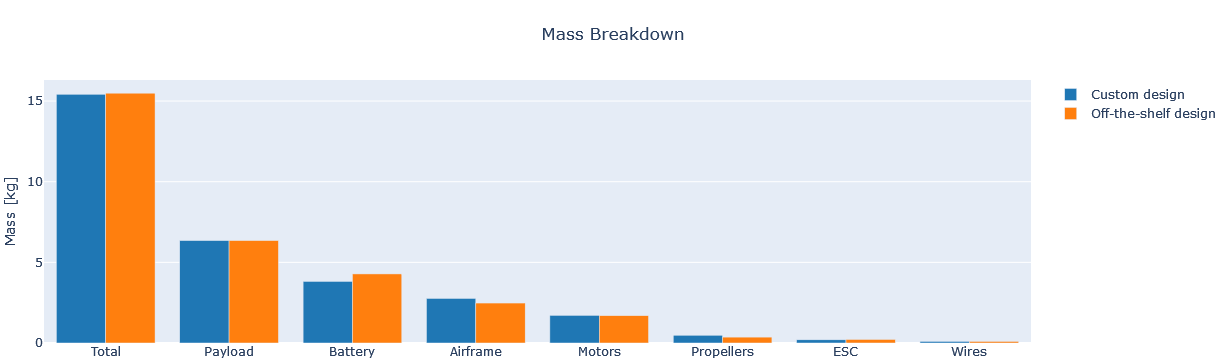

In [13]:
OUTPUT_FILE_CONTINUOUS = pth.join(DATA_FOLDER_PATH, "problem_outputs_DJI_M600_mdo.xml")
OUTPUT_FILE_DISCRETE = pth.join(DATA_FOLDER_PATH, "problem_outputs_discrete_DJI_M600_mdo.xml")

fig = mass_breakdown_bar_plot_drone(OUTPUT_FILE_CONTINUOUS, name="Custom design")
fig = mass_breakdown_bar_plot_drone(OUTPUT_FILE_DISCRETE, name="Off-the-shelf design", fig=fig)
fig.show()